In [1]:
import pickle
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [2]:
def Preprocess_GAN(train, label):
    # min max standardization
    # 創建一個MinMaxScaler對象
    scaler = MinMaxScaler()
    scaler = RobustScaler()
    # 選擇所有數值型列，並移除"BwdPSHFlags"
    numeric_columns = list(train.select_dtypes(include=['int', "float"]).columns)
    numeric_columns.remove("BwdPSHFlags")
    numeric_columns.remove(label)
    # 對每一個數值型列進行縮放
    for c in numeric_columns:
        train[c] = scaler.fit_transform(train[[c]])

    # get the true label of the train set
    true_label = train[label]

    # del train[label]
    return_df = train.drop(label, axis=1)
    return return_df, true_label

In [3]:
# Load the data
df = pd.read_csv('../datasets/target_model/CICIDS2017/target_model_CICIDS2017data.csv') #datasets\substitute_model\CICIDS2017\df_substitute_0311.csv
df = df.drop(columns=['Label'])

# modify column names Binary class to "Label"
df = df.rename(columns={'binary_classification': 'Label'})
df


,FlowDuration,TotFwdPkts,TotBwdPkts,TotLenFwdPkts,TotLenBwdPkts,FwdPktLenMin,FwdPktLenStd,BwdPktLenMax,BwdPktLenMean,BwdPktLenStd,...,SubflowFwdPkts,SubflowFwdByts,IdleStd,SubflowBwdPkts,SubflowBwdByts,InitBwdWinByts,FwdActDataPkts,ActiveStd,ActiveMax,Label
0,119970779,6,8,123,8,6,15.883954,31,13.125000,15.008926,...,6,123,1.920725e+07,8,105,55480,5,2.133558e+02,32779,benign
1,117591768,99,122,2547,122,0,94.293811,4344,1686.852459,1037.995945,...,99,2547,1.863627e+03,122,205796,1140,7,7.352316e+05,2453564,benign
2,609363,2,2,37,2,0,26.162951,6,6.000000,0.000000,...,2,37,0.000000e+00,2,12,0,1,0.000000e+00,0,benign
3,64039358,2,2,96,2,48,0.000000,48,48.000000,0.000000,...,2,96,0.000000e+00,2,96,-1,1,0.000000e+00,36695,benign
4,57329,1,1,48,1,48,0.000000,48,48.000000,0.000000,...,1,48,0.000000e+00,1,48,-1,0,0.000000e+00,0,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57567,102645877,14,3,2541,3,0,98.363337,6,2.000000,3.464102,...,14,2541,1.880000e+07,3,6,0,11,4.529980e+06,6406845,malicious
57568,3003648,3,0,0,0,0,0.000000,0,0.000000,0.000000,...,3,0,0.000000e+00,0,0,-1,0,0.000000e+00,0,malicious
57569,3003925,3,0,0,0,0,0.000000,0,0.000000,0.000000,...,3,0,0.000000e+00,0,0,-1,0,0.000000e+00,0,malicious
57570,102690607,14,3,2541,3,0,98.363337,6,2.000000,3.464102,...,14,2541,1.880000e+07,3,6,0,11,4.532999e+06,6411372,malicious


In [4]:
# change df column name
df.columns = df.columns.str.strip()

# df change column to another 35 th column
df = df[list(('FlowDuration', 'TotFwdPkts', 'TotBwdPkts', 'TotLenFwdPkts',
       'TotLenBwdPkts', 'FwdPktLenMin', 'FwdPktLenStd', 'BwdPktLenMax',
       'BwdPktLenMean', 'BwdPktLenStd', 'FlowByts/s', 'FlowPkts/s',
       'FlowIATStd', 'FwdIATTot', 'FwdIATMean', 'FwdIATMax', 'BwdIATMean',
       'BwdIATStd', 'BwdIATMax', 'BwdIATMin', 'BwdPSHFlags', 'FwdHeaderLen',
       'BwdHeaderLen', 'FwdPkts/s', 'BwdPkts/s', 'PktLenMax', 'PktLenStd',
       'FINFlagCnt', 'SYNFlagCnt', 'ACKFlagCnt', 'Down/UpRatio',
       'BwdSegSizeAvg', 'FwdHeaderLen.1', 'SubflowFwdPkts', 'SubflowFwdByts',
       'IdleStd', 'SubflowBwdPkts', 'SubflowBwdByts', 'InitBwdWinByts',
       'FwdActDataPkts', 'ActiveStd', 'ActiveMax', 'Label'))]


In [5]:
df.columns

Index(['FlowDuration', 'TotFwdPkts', 'TotBwdPkts', 'TotLenFwdPkts',
       'TotLenBwdPkts', 'FwdPktLenMin', 'FwdPktLenStd', 'BwdPktLenMax',
       'BwdPktLenMean', 'BwdPktLenStd', 'FlowByts/s', 'FlowPkts/s',
       'FlowIATStd', 'FwdIATTot', 'FwdIATMean', 'FwdIATMax', 'BwdIATMean',
       'BwdIATStd', 'BwdIATMax', 'BwdIATMin', 'BwdPSHFlags', 'FwdHeaderLen',
       'BwdHeaderLen', 'FwdPkts/s', 'BwdPkts/s', 'PktLenMax', 'PktLenStd',
       'FINFlagCnt', 'SYNFlagCnt', 'ACKFlagCnt', 'Down/UpRatio',
       'BwdSegSizeAvg', 'FwdHeaderLen.1', 'SubflowFwdPkts', 'SubflowFwdByts',
       'IdleStd', 'SubflowBwdPkts', 'SubflowBwdByts', 'InitBwdWinByts',
       'FwdActDataPkts', 'ActiveStd', 'ActiveMax', 'Label'],
      dtype='object')

In [6]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
df ['Label'] = lb.fit_transform(df['Label'])

In [7]:
X = df.drop(columns=['Label'], axis=1)
y = df['Label']

# Initial train test split set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


 # save datasets
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
df = train

train.to_csv(f'../datasets/surrogate_model/CICIDS2017/split_dataset/train_CICIDS2017.csv', index=False) 
test.to_csv(f'../datasets/surrogate_model/CICIDS2017/split_dataset/test_CICIDS2017.csv', index=False)

[Text(0, 0, '10970'), Text(0, 0, '4701')]

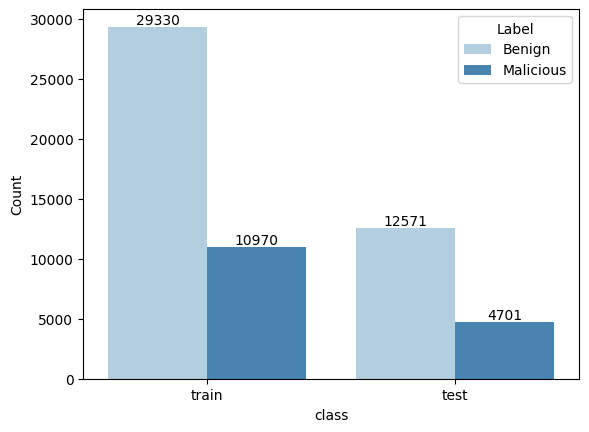

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_distribution = train.value_counts('Label')
train_distribution = train_distribution.reset_index()
train_distribution["class"] = "train"

test_distribution = test.value_counts('Label')
test_distribution = test_distribution.reset_index()
test_distribution["class"] = "test"

total_distribution = pd.concat([train_distribution, test_distribution])

total_distribution.columns = ["Label", "Count", "class"]
grade_map = {
    0: "Benign",
    1: "Malicious"}
total_distribution["Label"] = total_distribution["Label"].map(grade_map)

total_distribution
ax = sns.barplot(x="class", y="Count", hue="Label", data=total_distribution, palette="Blues" )
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')

In [9]:
# load the model from disk
dt_filename = '../target_model/ml_model/CICIDS2018target_dt.pickle' # Linear Regression
rf_filename = '../target_model/ml_model/CICIDS2018target_randomforest.pickle' # Decision Tree
xgb_filename = '../target_model/ml_model/CICIDS2018target_xgb.pickle' # xgboost
lr_filename = '../target_model/ml_model/CICIDS2018target_lr.pickle' # Linear Regression

dt_model = pickle.load(open(dt_filename, 'rb'))
rf_model = pickle.load(open(rf_filename, 'rb'))
xgb_model = pickle.load(open(xgb_filename, 'rb'))
lr_model = pickle.load(open(lr_filename, 'rb'))

In [10]:
data_train_original = pd.read_csv('../datasets/surrogate_model/CICIDS2017/split_dataset/train_CICIDS2017.csv')
data_train_original = data_train_original.drop(columns=['Label'])


### Generate Label from decision tree

In [11]:
from sklearn.preprocessing import MinMaxScaler
# generate predictions

# y_test_dt = df['Label']
# X_test_dt = df.drop(['Label'], axis=1)
X_test_dt, y_test_dt = Preprocess_GAN(train, 'Label')

y_test_dt_predicted = dt_model.predict(X_test_dt)
print("Classification report: \n", classification_report(y_test_dt, y_test_dt_predicted, target_names=['Benign', 'Malicious'], digits=4))

Classification report: 
               precision    recall  f1-score   support

      Benign     0.8358    0.9253    0.8783     29330
   Malicious     0.7201    0.5139    0.5998     10970

    accuracy                         0.8133     40300
   macro avg     0.7779    0.7196    0.7390     40300
weighted avg     0.8043    0.8133    0.8025     40300



In [12]:
# save the predicted data
df_dt = data_train_original.copy()
df_dt['DT_Predicted'] = y_test_dt_predicted
df_dt.to_csv('../surrogate_model/data_for_training/0322/df_dt_predicted_0322.csv', index=False)

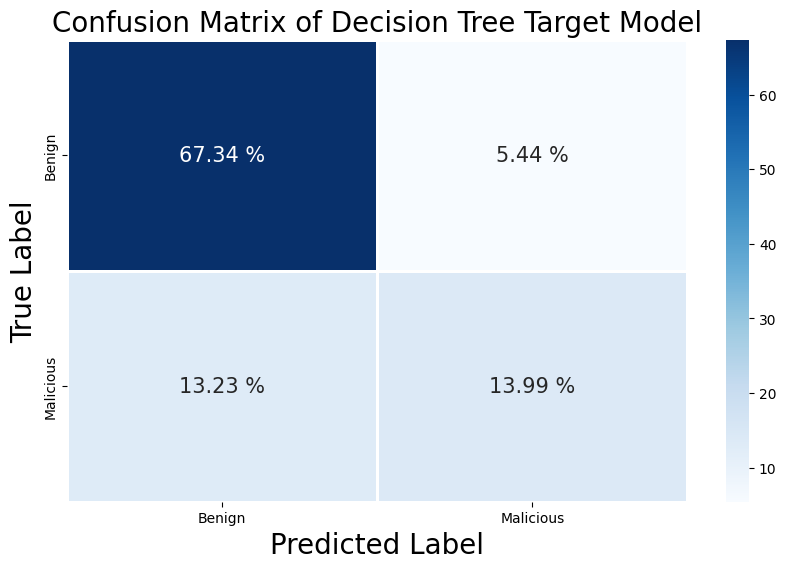

In [13]:
cm = confusion_matrix(y_test_dt, y_test_dt_predicted, labels=dt_model.classes_)
total = np.sum(cm)
confusion_percentage = (cm  / total) * 100

strings = np.asarray([['%', '%'],
                    ['%', '%']])
labels = (np.asarray(["{1:.2f} %".format(string, confusion_percentage) for string, confusion_percentage in zip(strings.flatten(), confusion_percentage.flatten())])).reshape(2, 2)
plt.figure(figsize=(10,6))
sns.heatmap(confusion_percentage, annot=labels, fmt='', cmap=plt.cm.Blues, linewidths=1, xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'], annot_kws={"size": 15})
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.title('Confusion Matrix of Decision Tree Target Model', fontsize=20)
plt.show()

### Generate Label from randomforest

In [14]:
# generate predictions

# y_test_rf = df['Label']
# X_test_rf = df.drop(['Label'], axis=1)

X_test_rf, y_test_rf = Preprocess_GAN(df, 'Label')
y_test_rf_predicted = rf_model.predict(X_test_rf)
print("Classification report: \n", classification_report(y_test_rf, y_test_rf_predicted, target_names=['Benign', 'Malicious'], digits=4))

Classification report: 
               precision    recall  f1-score   support

      Benign     0.8743    0.9902    0.9286     29330
   Malicious     0.9593    0.6194    0.7528     10970

    accuracy                         0.8893     40300
   macro avg     0.9168    0.8048    0.8407     40300
weighted avg     0.8975    0.8893    0.8808     40300



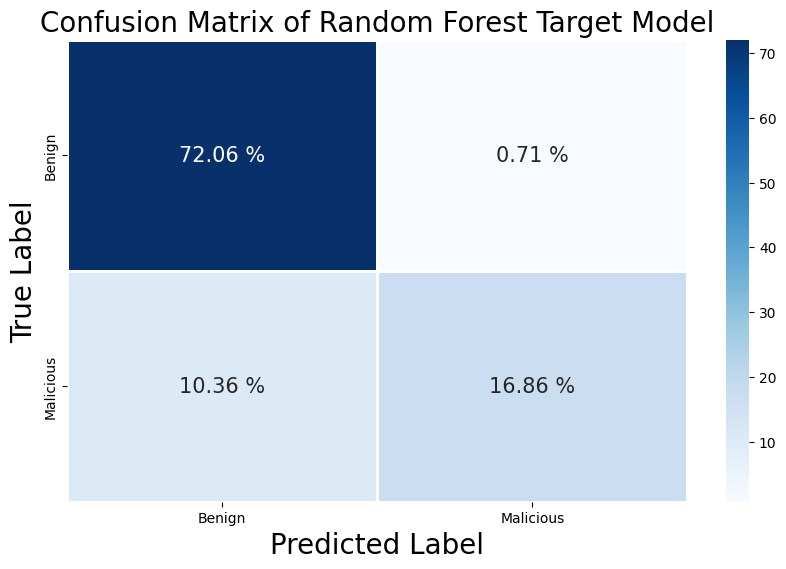

In [15]:
cm = confusion_matrix(y_test_rf, y_test_rf_predicted, labels=rf_model.classes_)
total = np.sum(cm)
confusion_percentage = (cm  / total) * 100

strings = np.asarray([['%', '%'],
                    ['%', '%']])
labels = (np.asarray(["{1:.2f} %".format(string, confusion_percentage) for string, confusion_percentage in zip(strings.flatten(), confusion_percentage.flatten())])).reshape(2, 2)
plt.figure(figsize=(10,6))
sns.heatmap(confusion_percentage, annot=labels, fmt='', cmap=plt.cm.Blues, linewidths=1, xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'], annot_kws={"size": 15})
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.title('Confusion Matrix of Random Forest Target Model', fontsize=20)
plt.show()

In [16]:
df_rf = data_train_original.copy()
df_rf['DT_Predicted'] = y_test_rf_predicted
df_rf.to_csv('../surrogate_model/data_for_training/0322/df_dt_predicted_0322.csv', index=False)


### Generate Label from xgboost

In [17]:
# generate predictions

# y_test_xgb = df['Label']
# X_test_xgb = df.drop(['Label'], axis=1)
X_test_xgb, y_test_xgb = Preprocess_GAN(df, 'Label')
y_test_xgb_predicted = xgb_model.predict(X_test_xgb)
print("Classification report: \n", classification_report(y_test_xgb, y_test_xgb_predicted, target_names=['Benign', 'Malicious'], digits=4))

Classification report: 
               precision    recall  f1-score   support

      Benign     0.9966    0.8935    0.9422     29330
   Malicious     0.7770    0.9918    0.8713     10970

    accuracy                         0.9203     40300
   macro avg     0.8868    0.9427    0.9068     40300
weighted avg     0.9368    0.9203    0.9229     40300



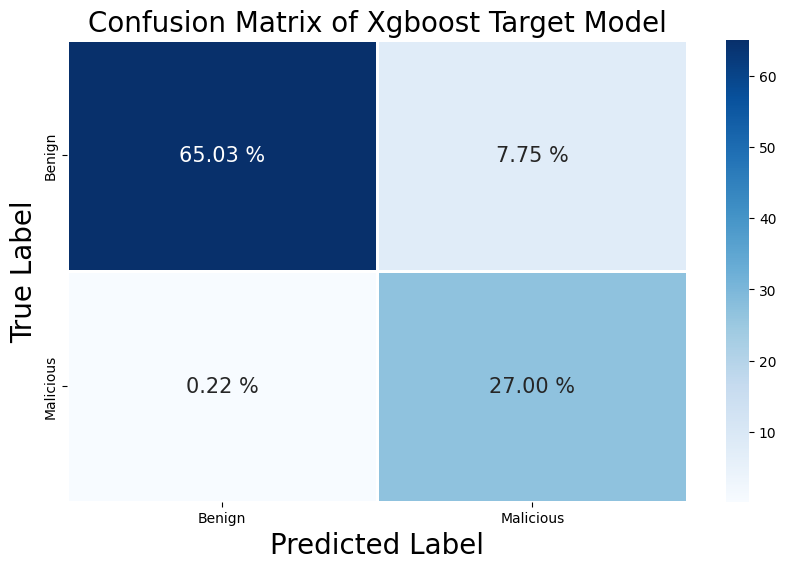

In [18]:
cm = confusion_matrix(y_test_xgb, y_test_xgb_predicted, labels=xgb_model.classes_)
total = np.sum(cm)
confusion_percentage = (cm  / total) * 100

strings = np.asarray([['%', '%'],
                    ['%', '%']])
labels = (np.asarray(["{1:.2f} %".format(string, confusion_percentage) for string, confusion_percentage in zip(strings.flatten(), confusion_percentage.flatten())])).reshape(2, 2)
plt.figure(figsize=(10,6))
sns.heatmap(confusion_percentage, annot=labels, fmt='', cmap=plt.cm.Blues, linewidths=1, xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'], annot_kws={"size": 15})
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.title('Confusion Matrix of Xgboost Target Model', fontsize=20)
plt.show()

In [19]:
df_xgb = data_train_original.copy()
df_xgb['XGB_Predicted'] = y_test_xgb_predicted
df_xgb.to_csv('../surrogate_model/data_for_training/0322/df_xgb_predicted_0322.csv', index=False)


### Generate Label from Logisitic Regression

In [20]:
# generate predictions

# y_test_lr = df['Label']
# X_test_lr = df.drop(['Label'], axis=1)
X_test_lr, y_test_lr = Preprocess_GAN(df, 'Label')
y_test_lr_predicted = lr_model.predict(X_test_lr)
print("Classification report: \n", classification_report(y_test_lr, y_test_lr_predicted, target_names=['Benign', 'Malicious'], digits=4))

Classification report: 
               precision    recall  f1-score   support

      Benign     0.7242    0.6421    0.6807     29330
   Malicious     0.2657    0.3462    0.3006     10970

    accuracy                         0.5615     40300
   macro avg     0.4949    0.4941    0.4907     40300
weighted avg     0.5994    0.5615    0.5772     40300



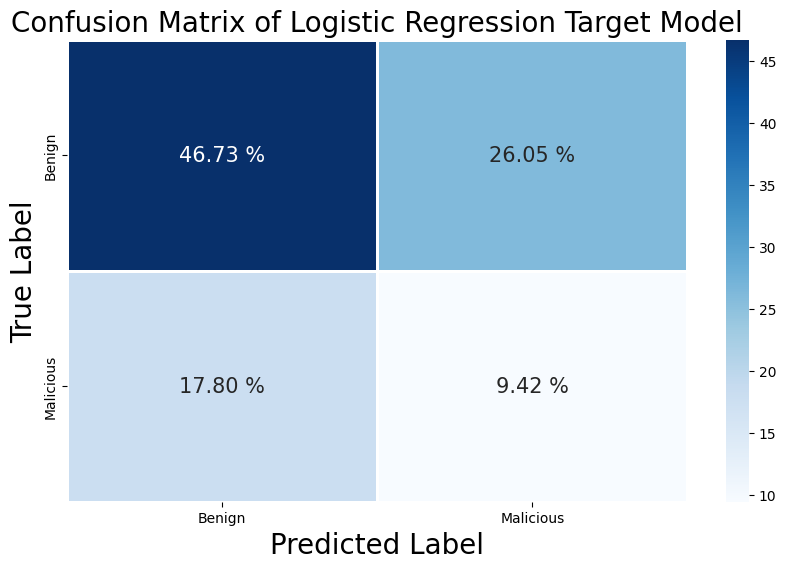

In [21]:
cm = confusion_matrix(y_test_lr, y_test_lr_predicted, labels=lr_model.classes_)
total = np.sum(cm)
confusion_percentage = (cm  / total) * 100

strings = np.asarray([['%', '%'],
                    ['%', '%']])
labels = (np.asarray(["{1:.2f} %".format(string, confusion_percentage) for string, confusion_percentage in zip(strings.flatten(), confusion_percentage.flatten())])).reshape(2, 2)
plt.figure(figsize=(10,6))
sns.heatmap(confusion_percentage, annot=labels, fmt='', cmap=plt.cm.Blues, linewidths=1, xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'], annot_kws={"size": 15})
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.title('Confusion Matrix of Logistic Regression Target Model', fontsize=20)
plt.show()

In [22]:
df_lr = data_train_original.copy()
df_lr['LR_Predicted'] = y_test_lr_predicted
df_lr.to_csv('../surrogate_model/data_for_training/0322/df_lr_predicted_0322.csv', index=False)


### Generate Label from DNN

In [23]:
# generate label for DNN
# X_test = df.drop(['Label'], axis=1)
# y_test = df['Label']
X_test, y_test = Preprocess_GAN(df, 'Label')
X_test_dnn, y_test_dnn = np.array(X_test), np.array(y_test)

In [24]:
## create dataloaders by myself
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


test_dataset = ClassifierDataset(torch.tensor(X_test_dnn).float(), torch.tensor(y_test_dnn).long())
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [25]:
import torch
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

###################### OUTPUT ######################
cuda:0

cpu


In [26]:
from torch import nn

class MaliciousClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MaliciousClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 256)
        self.layer_3 = nn.Linear(256, 128)
        self.layer_4 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.batchnorm4 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        #x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)
        #x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [27]:
# load the model from disk

num_feature = 42
num_class = 2
model = MaliciousClassification(num_feature, num_class)
model.load_state_dict(torch.load('../target_model/target_DNN_model/binaryclass/targetDNN_model_20240325_143114_50')) #target_model\target_DNN_model\binaryclass\targetDNN_model_20240312_170639_50.pt

y_pred_list_dnn = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred_dnn = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred_dnn, dim = 1)
        #print(_, y_pred_tags.cpu().numpy())
        y_pred_list_dnn.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list_dnn]

In [28]:
# test accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(accuracy_score(y_test, y_pred_list_dnn))

0.6678411910669975


In [29]:
y_test = y_test
print(classification_report(y_test, y_pred_list_dnn, target_names=['Benign', 'Malicious'], digits=4))

              precision    recall  f1-score   support

      Benign     0.9983    0.5445    0.7047     29330
   Malicious     0.4503    0.9975    0.6205     10970

    accuracy                         0.6678     40300
   macro avg     0.7243    0.7710    0.6626     40300
weighted avg     0.8491    0.6678    0.6818     40300



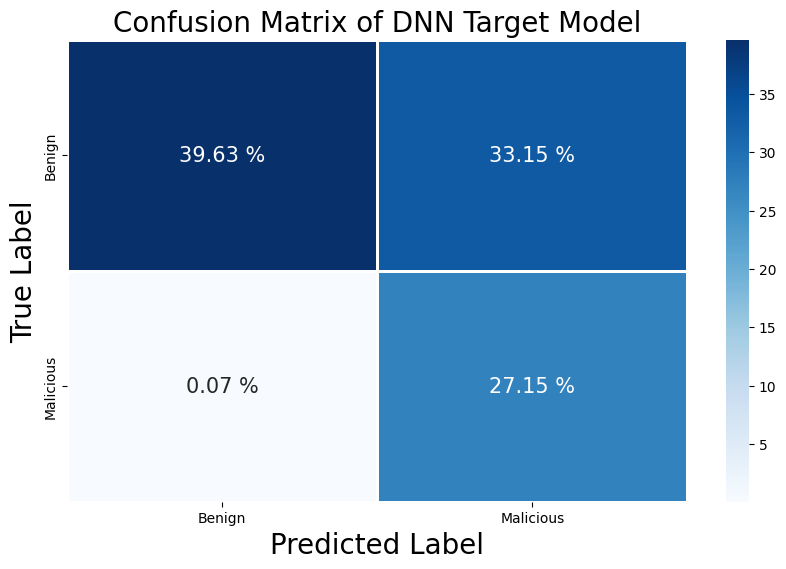

In [30]:
cm = confusion_matrix(y_test, y_pred_list_dnn, labels=df['Label'].unique() )
total = np.sum(cm)
confusion_percentage = (cm  / total) * 100

strings = np.asarray([['%', '%'],
                    ['%', '%']])
labels = (np.asarray(["{1:.2f} %".format(string, confusion_percentage) for string, confusion_percentage in zip(strings.flatten(), confusion_percentage.flatten())])).reshape(2, 2)
plt.figure(figsize=(10,6))
sns.heatmap(confusion_percentage, annot=labels, fmt='', cmap=plt.cm.Blues, linewidths=1, xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'], annot_kws={"size": 15})
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.title('Confusion Matrix of DNN Target Model', fontsize=20)
plt.show()

In [31]:
y_pred_list_dnn = [item for sublist in y_pred_list_dnn for item in sublist]
len(y_pred_list_dnn)

40300

In [32]:
df_dnn = data_train_original.copy()
df_dnn['DNN_Predicted'] = list(y_pred_list_dnn)
df_dnn.to_csv('../surrogate_model/data_for_training/0322/df_dnn_predicted_0322.csv', index=False)

### Save Data

### Split data into train and test

In [33]:
# Load data and do train test split
from sklearn.model_selection import KFold, cross_val_score, train_test_split


def load_data(filename, trainLabel, data_ml):
    # Load the data
    df = pd.read_csv(filename)
    # print(df.columns)
    X_predicted = df.drop(columns=[ trainLabel], axis=1)
    y_predicted = df[trainLabel]

    # Initial train test split set
        # Further split training set into training (70%) and validation (30%) sets
    X_train_predicted, X_test_predicted, y_train_predicted, y_test_predicted = train_test_split(X_predicted, y_predicted, test_size=0.1, random_state=42, stratify=y_predicted)

    # save datasets
    train_predicted = pd.concat([X_train_predicted, y_train_predicted], axis=1)
    test_predicted = pd.concat([X_test_predicted, y_test_predicted], axis=1)
    train_predicted.to_csv(f'../datasets/surrogate_model/CICIDS2017/split_dataset/train/train_{data_ml}_predicted.csv', index=False) 
    test_predicted.to_csv(f'../datasets/surrogate_model/CICIDS2017/split_dataset/train/test_{data_ml}_predicted.csv', index=False)
    
    return X_train_predicted, X_test_predicted, y_train_predicted, y_test_predicted

In [34]:
# Load data and do train test split
X_train_lr_predicted, X_test_lr_predicted, y_train_lr_predicted, y_test_lr_predicted = load_data('../surrogate_model/data_for_training/0322/df_lr_predicted_0322.csv', 'LR_Predicted', 'lr')
X_train_dt_predicted, X_test_dt_predicted, y_train_dt_predicted, y_test_dt_predicted = load_data('../surrogate_model/data_for_training/0322/df_dt_predicted_0322.csv', 'DT_Predicted', 'dt')
X_train_xgb_predicted, X_test_xgb_predicted, y_train_xgb_predicted, y_test_xgb_predicted = load_data('../surrogate_model/data_for_training/0322/df_xgb_predicted_0322.csv', 'XGB_Predicted', 'xgb')
X_train_dnn_predicted, X_test_dnn_predicted, y_train_dnn_predicted, y_test_dnn_predicted = load_data('../surrogate_model/data_for_training/0322/df_dnn_predicted_0322.csv', 'DNN_Predicted', 'dnn')